## Import necessary libraries

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Sequential
from keras.layers import Dense,Flatten
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.callbacks import EarlyStopping

In [2]:
#file path to training data
target_dir="C:/Users/navin/Downloads/archive (6)/New Masks Dataset/Train/"

In [3]:
#Defining categories of images
target_class=["with_mask",'without_mask']

### Iterating through each category and display 6 random images

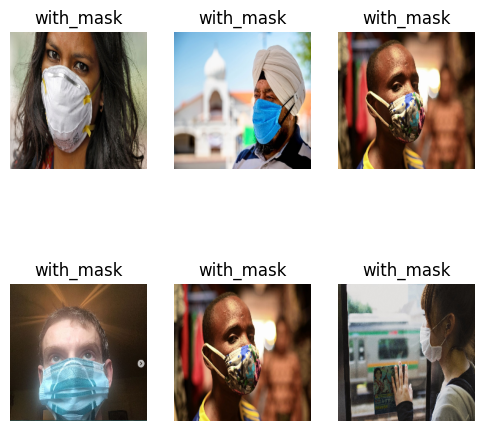

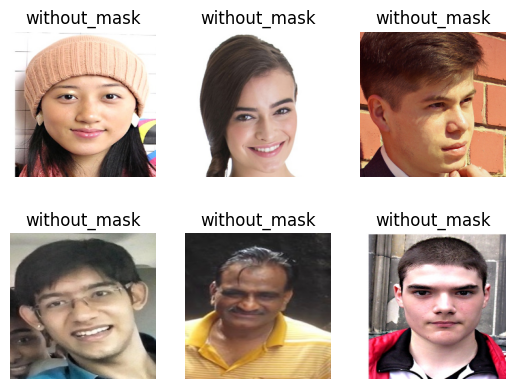

In [4]:
plt.figure(figsize=(6,6))

for i in target_class:
    target_folder = target_dir+i
    
    for j in range(6): 
        random_image = random.sample(os.listdir(target_folder),1)
        img=cv2.imread(target_folder+"/"+random_image[0])
        img= cv2.resize(img, (224,224))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        ax = plt.subplot(2, 3, j + 1)
        plt.imshow(img)
        plt.title(i)
        plt.axis("off")
        
    plt.show()

In [5]:
#appending the data and labels in mask folder into a list
data=[]
labels=[]
mask=os.listdir(target_dir+"/"+"with_mask/")
for a in mask:

    image = cv2.imread(target_dir+"/"+"with_mask/"+a)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(1)

In [6]:
len(labels)

350

In [7]:
##appending the data and labels in without_mask folder into a list
mask=os.listdir(target_dir+"/"+"without_mask/")
for a in mask:

    image = cv2.imread(target_dir+"/"+"without_mask/"+a)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(0)

In [8]:
len(labels)

700

### Converting data and labels lists to numpy arrays .

In [9]:
data = np.array(data)
labels = np.array(labels)

### Preprocessing the data using preprocess_input function from mobilenet_v2 module

In [10]:
data=preprocess_input(data)

In [11]:
data.shape

(700, 224, 224, 3)

### Splitting the data into train and test sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    data, labels, test_size=0.3, 
                                                    random_state=42,shuffle=True,
                                                    stratify = labels)

### loading the mobilenet pre-trained model

In [13]:
model1=tf.keras.applications.MobileNet(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    classes=2)

In [14]:
# Set all layers in MobileNet model to be untrainable
for layer in model1.layers:
        layer.trainable=False

In [15]:
#Creating new Sequential model
model2=Sequential()

In [16]:
#combining mobilenet model to our model
model2.add(model1)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [17]:
# final summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,090,689
Trainable params: 12,861,825
Non-trainable params: 3,228,864
____________________________________

In [18]:
#assigning optimizer and loss function to our model
model2.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
# Defining EarlyStopping callback to stop training when validation loss has not improved for 3 epochs
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

### Fitting the model on training,validation data for 10 epochs with batch size of 32

In [20]:
model2.fit(X_train, y_train, epochs=10,validation_split= 0.2, batch_size=32,callbacks=callback)

Epoch 1/10
14/14 [==============================] - 9s 571ms/step - loss: 0.3346 - accuracy: 0.8685 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 2/10
14/14 [==============================] - 7s 538ms/step - loss: 0.0043 - accuracy: 0.9977 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 3/10
14/14 [==============================] - 7s 537ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 4/10
14/14 [==============================] - 7s 537ms/step - loss: 7.3820e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 7s 535ms/step - loss: 6.2499e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/10
14/14 [==============================] - 7s 537ms/step - loss: 5.4141e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 7/10
14/14 [==============================] - 7s 538ms/step - loss: 4.7928e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accurac

In [24]:
#testing the model on test data appending the predicted labels
predictions = model2.predict(X_test)

predict=[]

for i in range(len(predictions)):
    if predictions[i][0]>0.5:
        predict.append(1)
    else:
        predict.append(0)

7/7 [==============================] - 3s 427ms/step


In [25]:
# building a dataframe with confusion matrix
conf_mat=pd.DataFrame(confusion_matrix(y_test, predict), columns= ["No Mask", "Mask"], index = ["No Mask", "Mask"])
conf_mat

,No Mask,Mask
No Mask,101,4
Mask,0,105


### Saving the model

In [23]:
model2.save("face_mask_detection.h5")